In [ ]:
import sys
sys.executable
import os
os.getcwd()
sys.path.append('devel/lib/python3/dist-packages/theconstruct_msgs/msg/')
sys.path.append('/home/nils/Documents/Studium/Bachelorarbeit/praktischer_Teil/moveo_DRL/src')
sys.path.append('/home/nils/Documents/Studium/Bachelorarbeit/praktischer_Teil/moveo_DRL/src/moveo_training/scripts')
sys.path.append('/home/nils/Documents/Studium/Bachelorarbeit/praktischer_Teil/moveo_DRL/devel/lib/python3/dist-packages/openai_ros/msg')

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.networks import actor_distribution_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()

import moveo_inverse_kinematic_discrete_MultiActions
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

2021-08-23 12:20:25.242706: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nils/Documents/Studium/Bachelorarbeit/praktischer_Teil/moveo_DRL/devel/lib:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu
2021-08-23 12:20:25.242726: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Failed to import pyassimp, see https://github.com/ros-planning/moveit/issues/86 for more info


In [ ]:
num_iterations = 10000 # @param {type:"integer"}
collect_episodes_per_iteration = 2 # @param {type:"integer"}
replay_buffer_capacity = 2000 # @param {type:"integer"}

fc_layer_params = (100,)

learning_rate = 1e-3 # @param {type:"number"}
log_interval = 25 # @param {type:"integer"}
num_eval_episodes = 10 # @param {type:"integer"}
eval_interval = 200 # @param {type:"integer"}

In [ ]:
import rospy
rospy.init_node("train_moveo_her")
env_name = 'MoveoIK_discrete_MultiActions-v0' # @param {type:"string"}
env = suite_gym.load(env_name)

###### Setting Group Moveit with 30 seconds wait...


[ERROR] [1629714031.480226, 75.603000]: NOT Initialising Simulation Physics Parameters
[WARN] [1629714031.506127, 75.629000]: Start Init ControllersConnection
[WARN] [1629714031.507607, 75.629000]: END Init ControllersConnection
/home/nils/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
env.reset()
# PIL.Image.fromarray(env.render())

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([0.56698513, 0.3       , 0.3       , 0.3       ], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})

In [ ]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[ 0. -1. -1. -1.], maximum=[2. 1. 1. 1.])
Action Spec:
BoundedArraySpec(shape=(5,), dtype=dtype('int32'), name='action', minimum=0, maximum=269)


In [ ]:
time_step = env.reset()
print('Time step:')
print(time_step)

# action = np.array(1, dtype=np.int32)

# next_time_step = env.step(action)
# print('Next time step:')
# print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([0.5670003, 0.3      , 0.3      , 0.3      ], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})


In [ ]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

###### Setting Group Moveit with 30 seconds wait...
###### Setting Group Moveit with 30 seconds wait...


[ERROR] [1629714033.399873, 77.434000]: NOT Initialising Simulation Physics Parameters
[WARN] [1629714033.422769, 77.456000]: Start Init ControllersConnection
[WARN] [1629714033.424022, 77.456000]: END Init ControllersConnection
[ERROR] [1629714033.824939, 77.829000]: NOT Initialising Simulation Physics Parameters
[WARN] [1629714033.858108, 77.854000]: Start Init ControllersConnection
[WARN] [1629714033.859670, 77.854000]: END Init ControllersConnection


In [ ]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [ ]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()

2021-08-23 12:20:34.448848: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-23 12:20:34.474841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-23 12:20:34.475352: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 970 computeCapability: 5.2
coreClock: 1.2155GHz coreCount: 13 deviceMemorySize: 3.94GiB deviceMemoryBandwidth: 208.91GiB/s
2021-08-23 12:20:34.475521: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nils/Documents/Studium/Bachelorarbeit/praktischer_Teil/moveo_DRL/devel/lib:/opt/ros/noetic/lib:/opt/ros

In [ ]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

In [ ]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# Please also see the metrics module for standard implementations of different
# metrics.

In [ ]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [ ]:
def collect_episode(environment, policy, num_episodes):

  episode_counter = 0
  environment.reset()

  while episode_counter < num_episodes:
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

    if traj.is_boundary():
      episode_counter += 1


# This loop is so common in RL, that we provide standard implementations of
# these. For more details see the drivers module.

In [ ]:
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few episodes using collect_policy and save to the replay buffer.
  collect_episode(
      train_env, tf_agent.collect_policy, collect_episodes_per_iteration)

  # Use data from the buffer and update the agent's network.
  experience = replay_buffer.gather_all()
  train_loss = tf_agent.train(experience)
  replay_buffer.clear()

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

[148  96 191 148  10]


[ WARN] [1629714036.622299497, 80.454000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[148  96 191 148  10]


[ WARN] [1629714037.529904001, 81.365000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[148  96 191 148  10]


[ WARN] [1629714038.379528629, 82.208000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[148  96 191 148  10]


[ WARN] [1629714039.204747165, 83.017000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[148  96 191 148  10]


[ WARN] [1629714040.094400458, 83.918000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[148  96 191 148  10]


[ WARN] [1629714040.935276236, 84.753000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[148  96 191 148  10]


[ WARN] [1629714041.816578369, 85.594000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[148  96 191 148  10]


[ WARN] [1629714042.646714335, 86.425000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[148  96 191 148  10]


[ WARN] [1629714043.540985581, 87.307000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[148  96 191 148  10]


[ WARN] [1629714044.250352805, 87.983000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[166  81 241 242  67]
[258  46   4 239 229]
Error setting joint target. Is the target within bounds?
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


2021-08-23 12:20:54.061261: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-23 12:20:54.089032: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3192610000 Hz


[185 194  48  26  17]


[ WARN] [1629714054.998812551, 98.367000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 38 151 153   7 192]
[188  63 191 264 219]
[217 134 269 161 250]


[ WARN] [1629714071.317324760, 115.718000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 15  49  76 225 149]
Error setting joint target. Is the target within bounds?
[217  80 197  69 254]


[ WARN] [1629714072.616664352, 119.366000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 54 256 241 258  61]


[ WARN] [1629714074.060323263, 123.755000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[269 263 217  49  98]
Error setting joint target. Is the target within bounds?
[ 44 112  50 194  58]
[131 106 248 252  97]
[  8 117 193 211  72]
Error setting joint target. Is the target within bounds?
[182 173 256 148 220]
[116 137  82 120  58]
[  9  66  95 124   4]
Error setting joint target. Is the target within bounds?
[190 198  97  22 146]
[269 216 127  82 187]
Error setting joint target. Is the target within bounds?
[ 94 198 172 265  71]
[189 103  64  63 142]
[  5  82 226 141  89]
Error setting joint target. Is the target within bounds?
[ 81 128  80  48 138]
[175 169  51 119  27]
[ 63 150 115  78 150]
[258  62 212 175  17]
Error setting joint target. Is the target within bounds?
[249  41 243  91 183]
[ 64  82  87  97 215]
[ 97 146 120 148 223]
[127 138  45 196 267]


[ WARN] [1629714098.043143879, 1002.214000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 19 240  44 165  38]
Error setting joint target. Is the target within bounds?
[209 224  35 127  67]
[156 148  25 214 245]
[185 128 218 185  44]
[ 54 199  76  30 157]
[ 35 205  43 265 210]
[  2 264 130  90 167]
Error setting joint target. Is the target within bounds?
[142 211  12  10 209]
[255 154 205 227 215]
Error setting joint target. Is the target within bounds?
[148 265 213  63  92]
[ 25 113 105 263 191]
[224 207  38 230 131]
[ 14 239 116  10 125]
Error setting joint target. Is the target within bounds?
[ 28 257  14 199 202]
[219 165  61 267  56]
[  6 103 127  58 264]
Error setting joint target. Is the target within bounds?
[135 106 244 113  10]


[ WARN] [1629714118.663576820, 1920.364000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[135 230 179 102 157]
[ 96  18 261 118 253]


[ WARN] [1629714120.879575674, 2014.414000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[105  41 205  78  69]
[183  96  41  20 225]
step = 25: loss = -5.695989608764648
[ 80 183  26  95 269]


[ WARN] [1629714125.424892054, 2156.254000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 54 138  37  65  82]
[101 209 129  10  19]


[ WARN] [1629714127.793167455, 2230.124000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[194  41 145 184   3]


[ WARN] [1629714128.516606783, 2242.204000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[  8 101 111 155 241]
Error setting joint target. Is the target within bounds?
[117  40  24  94  44]


[ WARN] [1629714130.046138906, 2278.084000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 16 208 133 112 175]
Error setting joint target. Is the target within bounds?
[251 251 251  38  10]
Error setting joint target. Is the target within bounds?
[ 58  72 146 238   7]


[ WARN] [1629714132.435847696, 2359.954000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[125  57  97  56 211]
[ 68 107  50 142 132]
[ 48  36 142  81   0]
[ INFO] [1629714029.309319982]: Loading robot model 'moveo_description'...
[ INFO] [1629714029.311749743]: No root/virtual joint specified in SRDF. Assuming fixed joint
[ INFO] [1629714031.437181352, 75.561000000]: Ready to take commands for planning group arm.
[ INFO] [1629714032.814292048, 76.904000000]: ABORTED: Solution found but controller failed during execution
[ INFO] [1629714033.361813125, 77.404000000]: Ready to take commands for planning group arm.
[ INFO] [1629714033.793553651, 77.804000000]: Ready to take commands for planning group arm.
[ INFO] [1629714036.778741609, 80.613000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1629714037.245252523, 81.074000000]: ABORTED: Solution found but controller failed during execution
[ INFO] [1629714037.735389059, 81.572000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1629714038.111863262, 81.945000000]: ABORTED: Solution fo

[ WARN] [1629714135.747725302, 2464.884000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[139 194  55 256 245]
[ 43  87  37 262 100]
[150 118  58 111 170]
[228 181  14  79 260]


[ WARN] [1629714143.316341755, 2669.184000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[187  95 206 114  84]
[ 62 128 186 225  66]
[179 201 145  48 221]
[123 180 245  15  75]
[ 32  15 192  55 185]
[ 30 181  26 172 221]
[ 14 265 183  66  24]
Error setting joint target. Is the target within bounds?
[ 60 233   4  41 219]
[251  48  19 255 196]
Error setting joint target. Is the target within bounds?
[187 237 115 131  20]


[ WARN] [1629714157.979707410, 3148.024000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[255   8 189 227  66]
Error setting joint target. Is the target within bounds?
[ 32  95 108  11  12]


[ WARN] [1629714159.897403689, 3242.624000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 38 249  13 147 239]
[103  47 128  55  72]
[175  22 169 186 125]
[152 226 214 191  33]
[251 214 181  88  30]
Error setting joint target. Is the target within bounds?
[221 177 161 180  95]
[72  9 59 81 38]


[ WARN] [1629714171.052640837, 3545.484000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[151  28  43  79 232]
[109 171 229  17  21]


[ WARN] [1629714174.477171593, 3645.704000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[244 202 251  29 220]
[ 48  90 200 116  55]
[ 25 163 247  43 222]
[  7 156 262   2 182]
Error setting joint target. Is the target within bounds?
[256 140 259 177 189]
Error setting joint target. Is the target within bounds?
[ 18  90 163 181 145]
Error setting joint target. Is the target within bounds?
[142 190 259  97 154]
[196 102 100  77 137]
[205 130 139  87 248]


[ERROR] [1629714185.472031798, 3996.154000000]: Got a callback on a goalHandle that we're not tracking.                 This is an internal SimpleActionClient/ActionClient bug.                 This could also be a GoalID collision


[ 36  16 115 127  75]
[ 49 128  63  34 250]


[ WARN] [1629714189.069368926, 4115.624000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[252  48 223 264 111]
Error setting joint target. Is the target within bounds?
[133 137 200 189 230]


[ERROR] [1629714190.587038769, 4181.744000000]: Got a callback on a goalHandle that we're not tracking.                 This is an internal SimpleActionClient/ActionClient bug.                 This could also be a GoalID collision


step = 50: loss = -16.37259292602539
[265 260 176  40 115]
Error setting joint target. Is the target within bounds?
[265 260 176  40 115]
Error setting joint target. Is the target within bounds?
[265 260 176  40 115]
Error setting joint target. Is the target within bounds?
[265 260 176  40 115]
Error setting joint target. Is the target within bounds?
[265 260 176  40 115]
Error setting joint target. Is the target within bounds?
[265 260 176  40 115]
Error setting joint target. Is the target within bounds?
[265 260 176  40 115]
Error setting joint target. Is the target within bounds?
[265 260 176  40 115]
Error setting joint target. Is the target within bounds?
[265 260 176  40 115]
Error setting joint target. Is the target within bounds?
[265 260 176  40 115]
Error setting joint target. Is the target within bounds?
step = 50: Average Return = -1000.0
[ 79  81  12 131 136]
[171  16   7 176   8]


[ WARN] [1629714197.126847358, 4439.934000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[178 170 263 250 174]
[177  21 186 256 137]
[178  72 188 120 244]
[216 147 101  80 140]
[216  38 173 222 113]
[ 35 144  93  35 106]
[220   8 207 193 129]
[  8 172 231 104 101]
Error setting joint target. Is the target within bounds?
[154  19  94 124 107]
[267 214 162 153  60]
Error setting joint target. Is the target within bounds?
[184 181 109 115  24]
[ 52 170  19  30 236]
[159  66 110   2  48]
[  0 176  81 144  43]
Error setting joint target. Is the target within bounds?
[179 188  48  31  63]
[231 111 242  45 249]


[ WARN] [1629714219.619186002, 5144.994000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 40 134  55 132 103]
[157  22 244 127 240]
[ 36 184  89 128 224]
[201  13 128  59  65]
[  2 166 230  85 131]
Error setting joint target. Is the target within bounds?
[  8 181 105  32 176]
Error setting joint target. Is the target within bounds?
[217 127 120  90 139]
[222  44 232 170 225]
[202 164 222 231 110]
[ 76 213  97  69 252]


[ WARN] [1629714233.262888238, 5599.784000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[102  72 249  11 219]
[171   3 165  85 148]
[254 210 199  76  40]
Error setting joint target. Is the target within bounds?
[239 137   8  24 240]
[126 120 153 145  59]
[ 41 237  98  44  89]
[ 61 247 190 200 192]
[ 70 120 258  43 111]
[ 88 161 248 203  55]
[ 58 141 248  50  90]
[ 85 197  13 138 216]
[233 206  15 225 105]
[ 11 262 227 195 124]
Error setting joint target. Is the target within bounds?
[222 184  18 239  62]
[173 263 168 183 131]
[  3 159  92 127  10]
Error setting joint target. Is the target within bounds?
[208 166 167  41 207]
[218  24 170  24 108]
[122  55 186 118 241]
[ 82 114 215  36 114]
[231  43 156  28 102]
[218  18  17 187  25]


[ WARN] [1629714265.411332076, 6637.754000000]: Fail: ABORTED: No motion plan found. No execution attempted.


step = 75: loss = -18.86216163635254
[239 223  90  67  78]
[ 73 191   3 235 136]
[ 11 266  36 240 227]
Error setting joint target. Is the target within bounds?
[ 74  89 131   1 188]
[152 189 206 227  51]
[244 162  41 233  97]
[ 78 246  72 180 237]
[184  30 227 216 241]
[171 251 181  18 174]
[ 45  53  86  87 222]
[ 98  84 115 103  91]
[178 102 174 173 207]
[235  84  48  46  22]


[ WARN] [1629714285.943564866, 7467.684000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 86 100 242 168 170]
[183 191 249 237 121]
[ 40 110 220  17 149]
[227 114 144 265  56]
[ 43 219 242 164 205]


[ WARN] [1629714293.887632779, 7786.984000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 64 100  23 236  35]
[149 107  42 200   8]


[ WARN] [1629714296.980533359, 7872.454000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[144 193 120 130 140]
[108   1   9 166  41]


[ WARN] [1629714299.134821577, 7971.364000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[  7   3 179  77 145]
Error setting joint target. Is the target within bounds?
[130  56 196 242 202]
[ 93 261  75  89 176]
[171 193 212 241 150]
[ 96  78 256 189 218]
[227 107   5  65  97]
[117 252 170  55   9]


[ WARN] [1629714308.636139568, 8282.424000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 47 261 249  65 256]


[ WARN] [1629714309.188470903, 8302.604000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 89  92 156 144 102]
[230 241  57 171 250]


[ WARN] [1629714311.398170897, 8378.004000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[194 105   7 182  42]
[ 77 232  75  29  68]
[ 66 220  16  34 119]
[217 215 206 251 186]
[165  73 193 247 204]
[113 217 113  56 205]
[ 38 114 204  67 261]


[ WARN] [1629714323.641417372, 8814.754000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[236 102  90  41   5]


[ WARN] [1629714324.385105731, 8857.764000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[151  70  52   3 108]
[174  21 170 105 163]
[249 122 156  93 121]
[215 161 185 265 152]
[199 266 258 233  72]


[ WARN] [1629714331.140669050, 9093.254000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[119  15 155 133   8]


[ WARN] [1629714331.928415260, 9117.414000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 38 105  67  95 157]
[ 71 131 185  15  18]


[ WARN] [1629714334.080076008, 9212.184000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[119 173  57  37 216]
[ 95  38 185  46  22]


[ WARN] [1629714336.509901860, 9324.244000000]: Fail: ABORTED: No motion plan found. No execution attempted.


step = 100: loss = -14.694929122924805
[265 260 176 245 115]
Error setting joint target. Is the target within bounds?
[265 260 176 245 115]
Error setting joint target. Is the target within bounds?
[265 260 176 245 115]
Error setting joint target. Is the target within bounds?
[265 260 176 245 115]
Error setting joint target. Is the target within bounds?
[265 260 176 245 115]
Error setting joint target. Is the target within bounds?
[265 260 176 245 115]
Error setting joint target. Is the target within bounds?
[265 260 176 245 115]
Error setting joint target. Is the target within bounds?
[265 260 176 245 115]
Error setting joint target. Is the target within bounds?
[265 260 176 245 115]
Error setting joint target. Is the target within bounds?
[265 260 176 245 115]
Error setting joint target. Is the target within bounds?
step = 100: Average Return = -1000.0
[  2   6 202  10  73]
Error setting joint target. Is the target within bounds?
[114  41 139 183  25]
[246 212 177 259 230]
[123 173  7

[ WARN] [1629714346.404121976, 9697.574000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[148 238 229 131  52]
[80 64 68 77 70]
[266 249 115 118 227]
Error setting joint target. Is the target within bounds?
[ 16 223  94   0 171]
Error setting joint target. Is the target within bounds?
[218 157 258 177  34]
[ 71 173 141 131 163]
[ 95 110  89 251   4]


[ WARN] [1629714356.047403371, 9974.724000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[114 218 123 118 184]
[ 26 242  13 172  17]


[ WARN] [1629714358.550714446, 10073.984000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 31 267 261  11 151]


[ WARN] [1629714359.556215828, 10127.214000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 21 122 196 156 180]


[ERROR] [1629714360.003179939, 10138.484000000]: Got a callback on a goalHandle that we're not tracking.                 This is an internal SimpleActionClient/ActionClient bug.                 This could also be a GoalID collision


[  1  61 168 216 117]
Error setting joint target. Is the target within bounds?
[149  78 146 259 119]
[ 33 174 227 258 102]
[104 112 147 201 134]
[132  23  83 267  27]
[214 120 134  57 115]
[114  24  57  67 236]
[253 185 187  86 111]
Error setting joint target. Is the target within bounds?
[245 109  60  92  72]
[  2  53 171  56  12]
Error setting joint target. Is the target within bounds?
[ 24 209   9 177  16]


[ WARN] [1629714375.332221315, 10704.464000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[138  70  36 199  15]


[ WARN] [1629714376.753405086, 10771.894000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 96 203 131  47  20]


[ WARN] [1629714378.177789621, 10817.514000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 77  86 167 143   8]


[ WARN] [1629714378.962843261, 10844.344000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 95 116 225 118  99]


[ERROR] [1629714380.440766328, 10892.524000000]: Got a callback on a goalHandle that we're not tracking.                 This is an internal SimpleActionClient/ActionClient bug.                 This could also be a GoalID collision


[115  74 214 252 247]
[ 82  83  89 265  65]
[159  27 138  50  70]
[257 265 155 261  45]
Error setting joint target. Is the target within bounds?
[ 51  39  53  85 198]


[ WARN] [1629714388.587203088, 11075.954000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[232 183 177 124  36]
[ 46 260 123 187  32]
[138 104 101 109 223]
[180 105  27  73  36]
[ 63 123 158  31 130]
[190 111 137 205  47]
[200 231  99 219 259]


[ WARN] [1629714399.280414119, 11456.394000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[187 197  68  74 108]
[ 99  53 226  21 114]
[228  47  44 266 172]
[164 107  63  89  98]
[206 202  56  24  49]
[104  66 122 222 148]
[113 116 242 230  95]
step = 125: loss = -3.0188913345336914
[61 32 35 23 11]


[ WARN] [1629714411.293383713, 11846.634000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 12 123 138 218 246]
Error setting joint target. Is the target within bounds?
[ 25 142  50  70  35]
[ 99 220 171  13   3]


[ WARN] [1629714413.942834164, 11953.774000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[146 161 253 121   6]


[ WARN] [1629714414.781238948, 11981.844000000]: Fail: ABORTED: No motion plan found. No execution attempted.


35.835624943, 2468.134000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1629714143.411455518, 2671.004000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1629714158.236446460, 3154.434000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1629714160.045196398, 3249.324000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1629714171.525473487, 3558.464000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1629714174.702368588, 3650.534000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1629714189.467475769, 4141.564000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1629714197.201867885, 4441.644000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1629714220.176162895, 5171.294000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1629714233.710047879, 5608.964000000]: ABORTED: No motion plan found. No executio

[ WARN] [1629714415.738276139, 12010.254000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[214  74 237 119 143]
[ 84  85  22 260  41]
[113 262 223  89  31]


[ WARN] [1629714420.462156815, 12221.494000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[268 107 162 267  69]
Error setting joint target. Is the target within bounds?
[ 60  32 235   0 163]
[240 101 169 112 266]


[ WARN] [1629714423.582659741, 12395.914000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[124  12 142 178  98]
[149 254   4 258 109]
[110 110 216 257  49]
[ 82 209 104  99   3]


[ WARN] [1629714429.020783602, 12590.344000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[122 229 229 178  65]
[175  83 178 241 260]


[ WARN] [1629714431.914817765, 12658.204000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 89 236 167  42  70]
[157 178 207 130 122]
[158 136 232 173 199]
[226 136  28 132  34]
[ 52  66 107 129 120]
[ 81 241  95  85  40]
[214  79 180 110 214]
[168 110 225  71  46]
[ 27  51 137  35  47]
[143 165 255  73 252]


[ WARN] [1629714446.247503682, 13156.554000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[106  76 257  77 137]
[ 24 133 157 192 135]
[174  12 239 158   9]


[ WARN] [1629714450.675225662, 13345.584000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[114 179 218  32 173]
[237   0 239 126  59]
[237 137 200 255 134]
[160 181  86   6 210]
[198 201 154  13  31]
[135 184  11  90  61]
[218 152  36 232 223]
[ 71  22 170  68 247]
[244 240  52 111 170]
[143 223 174  89  48]
[195 219 144 224 264]


[ WARN] [1629714468.372753886, 14043.814000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 65  14 199 218 253]


[ WARN] [1629714469.216279234, 14064.394000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[125  75 263  90 174]
[213  11 121 123 235]
[102 117  39  57 171]
[113 210 221 193 249]


[ WARN] [1629714474.911981909, 14253.674000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[117 256 230  51 160]


[ WARN] [1629714476.030242348, 14305.894000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[208  30 176  14  32]
[159  30 263 233 248]
step = 150: loss = -19.39781379699707
[248 187 159 245 208]
[248 187 159 245 208]
[248 187 159 245 208]
[248 187 159 245 208]
[248 187 159 245 208]
[248 187 159 245 208]
[248 187 159 245 208]
[248 187 159 245 208]
[248 187 159 245 208]
[248 187 159 245 208]
step = 150: Average Return = -2.0067121982574463
[244  94  20 154   7]


[ WARN] [1629714495.419898714, 14906.664000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[226 171 171 155 208]
[149 209  53  99 246]
[136  34 229 233 112]
[183  35 217  45 178]
[234  28 215 108  53]
[169 190  92 120 193]
[ 45  69 141 149 250]


[ WARN] [1629714505.012011031, 15267.704000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[139  91  54 211  95]
[220  60  46   4 165]
[182 157  20  57  62]
[113 135   4 227  63]
[215 160 132 258  69]
[ 39 237   9 162  16]


[ WARN] [1629714513.823139470, 15583.594000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[185  97  94 150   6]


[ WARN] [1629714515.194168539, 15619.304000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[253  10  94  50 252]
Error setting joint target. Is the target within bounds?
[230 141 224 269 201]
[207 224 215  39 164]
[110 227  21 153  96]
[ 61 174 199 141 199]
[213 180 121  94 230]
[118 232  15 251 157]
[ 23 131 228 241  79]
[ 11 257  31 198 145]
Error setting joint target. Is the target within bounds?
[144 187  65 139 205]
[157 198  95 159 198]
[214 254 205 226 120]


[ WARN] [1629714535.745319770, 16064.754000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 87 162  13 144 206]
[223  52  23 170  23]


[ WARN] [1629714538.560727792, 16190.874000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 12  25 220  71 206]
Error setting joint target. Is the target within bounds?
[ 68  77 219 188  59]
[265 235 164 179   0]
Error setting joint target. Is the target within bounds?
[178 134 135  52 127]
[111 174 202 244  79]
[ 82 198 215 241  44]
[ 20 241 189  96 155]
Error setting joint target. Is the target within bounds?
[172 115 227 102 242]
[ 85  53  98 237  28]
[237  99  75 259 232]
[170 192  21 238  74]
[158  53 204 157   8]


[ WARN] [1629714554.655618188, 16795.314000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[259 198 238 205 194]
Error setting joint target. Is the target within bounds?
[ 65 266 205  93 203]
[166  29 208  36 137]
[233  63  73 155 146]
[ 31 215  24  39 252]


[ WARN] [1629714561.404972740, 16979.244000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[213 113 246  56   9]


[ WARN] [1629714563.588319623, 17019.994000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[161  45 255 162  54]
[  6 117 127 215 217]
Error setting joint target. Is the target within bounds?
[171  97 246 186 170]
step = 175: loss = -16.60852813720703
[260 268 167  91 119]
Error setting joint target. Is the target within bounds?
[ 99 101  66  81 181]
[237 179  57  42 197]
[122 224 181   5  95]
[267 259  93 222 269]
Error setting joint target. Is the target within bounds?
[ 48 250  44 247 135]
[ 22 104 196 169  73]
[ 17   0 254 229 109]
Error setting joint target. Is the target within bounds?
[149 221  22  78 130]
[136  80 220  54  98]
[ 88  20 118 218 253]


[ WARN] [1629714582.430675912, 17687.364000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[176  30  33  97 238]


[ WARN] [1629714583.229327552, 17705.694000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[207  35  27 182 245]


[ WARN] [1629714585.013399005, 17783.814000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 89 262 258   5 215]


[ WARN] [1629714586.595081147, 17866.624000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 49 179  59 119  58]
[133 111 264 127 236]


[ WARN] [1629714589.951406026, 17982.024000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 31 197 113 154  95]
[107  46 219 159  44]
[221 155 240 160  48]
[ 28 245  74 151 173]
[ 32 175  34  63 104]
[137  62  39 141 140]
[162 241 124 210  93]
[ 90  56  70  61 162]
[232 245 136 216 260]


[ WARN] [1629714604.414170357, 18515.554000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[186 111 201  60 130]
[225 120   1 203 264]


[ WARN] [1629714606.502952402, 18565.064000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 91 247 171 138 154]
[ 57 218 264 174 153]


[ WARN] [1629714608.941156145, 18618.114000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[154 173 235   6 102]
[ 31   1 151  33  64]


[ WARN] [1629714612.040722124, 18679.194000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[243 110  93 198 255]


[ WARN] [1629714612.890822898, 18696.624000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[219  12   8 145 252]


[ WARN] [1629714613.778990558, 18714.984000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[172  63 248  85  68]
[251  37  93  23 235]
Error setting joint target. Is the target within bounds?
[128 254 268 263 159]


[ WARN] [1629714616.638379242, 18810.514000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 68  90 264  62  74]
[111 137 222 137 240]
[ 10 257  57 134 101]
Error setting joint target. Is the target within bounds?
[ 55 101 224 102 215]
[185 129 230 108 226]
[248  39   5  26 188]


[ WARN] [1629714623.649193075, 19121.264000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[252 158   1  13 167]
Error setting joint target. Is the target within bounds?
[160   4 265 101 101]
[163 210 188   9  74]
[229  71 252  54 155]
[207 109  61 114 226]
[ 50  42 215 207   4]


[ WARN] [1629714631.571317339, 19351.674000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 98  71  84 134  43]
[ 53 228 228 252 226]
step = 200: loss = -1.864302635192871
[145 125 159 107 158]
[145 125 159 107 158]
[145 125 159 107 158]
[145 125 159 107 158]
[145 125 159 107 158]
[145 125 159 107 158]
[145 125 159 107 158]
[145 125 159 107 158]
[145 125 159 107 158]
[145 125 159 107 158]
step = 200: Average Return = -5.672918796539307
[ 78  16  84 171  31]
[196  56  67  22 127]
[ 50 229 160 188 133]
[118 231  89 138 243]
[ 96 174  94 127 262]


[ WARN] [1629714652.670389042, 20061.074000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[256 158 243 228 120]
Error setting joint target. Is the target within bounds?
[162 232  29 167  76]
[213 187  71 136 261]

[ INFO] [1629714415.822677184, 12012.674000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1629714421.118385729, 12270.664000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1629714423.711731342, 12402.464000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1629714429.096009318, 12592.524000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1629714432.018788317, 12660.344000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1629714446.767196202, 13178.904000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1629714450.831096051, 13350.854000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1629714468.456004853, 14045.714000000]: ABORTED: No motion plan found. No execution attempted.
[ INFO] [1629714469.723977042, 14085.5540000

[ WARN] [1629714655.689440876, 20150.134000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 34 195  27  89 179]
[138 161 176  61 123]
[ 86  15 154  49  28]
[118 176 260  90 179]
[238  36  62  46  99]
[203 132  32 249  32]
[177  77  72  64  79]
[223  21 245 215 127]
[240  86 255 199 162]
[ 91 153  74  39 197]
[110  19 126 101 116]
[125  68 154 261  41]
[192 226 219 213  37]
[204 120 165 256  43]
[245  14  32 186 107]


[ WARN] [1629714680.666570909, 20886.264000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[191 200 235 108 171]
[106 221 258 143  39]


[ WARN] [1629714683.447751429, 20942.924000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[128  97 238 146  93]
[ 37  11 159  12  26]


[ WARN] [1629714686.264512333, 21035.254000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[233 114 237 169 208]
[107 102 105  35 181]
[21 66 47 93  0]


[ WARN] [1629714689.809208978, 21208.064000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[263  13 150 158  99]
Error setting joint target. Is the target within bounds?
[ 50 241  14 112  12]


[ WARN] [1629714691.029938117, 21296.744000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 39 261 240  92  17]


[ WARN] [1629714691.962757403, 21320.884000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[138 125  53 160  57]
[ 86 159  80 133  44]
[168  37  40  11  85]
[247 153 256 179 168]
[186 182 254 156   2]


[ WARN] [1629714698.541733466, 21617.364000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 62 168  84  12 234]
[ 97  98 178 245 254]


[ WARN] [1629714700.808695755, 21701.314000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[158 151 182  61  50]
[261 170 108  49   3]
Error setting joint target. Is the target within bounds?
[ 78  54  72  73 132]
[139 136  12 114 103]
[ 93 258 166 219 234]
[177 232 121  34 255]


[ WARN] [1629714708.170079280, 21977.124000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[223 172 146 185  90]
[242 131 254 228  11]


[ WARN] [1629714710.492401625, 22098.044000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 65 168  50 250   1]


[ WARN] [1629714711.417775681, 22142.304000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[261  12 152  72  81]
Error setting joint target. Is the target within bounds?
step = 225: loss = 0.7144031524658203
[ 70 196 184  14 103]
[154 258  68 262  60]
[ 13 186  99  61 151]
Error setting joint target. Is the target within bounds?
[ 80 201 243 189 128]
[ 92 140 251 220  42]
[ 85 169 237 106 141]
[ 74 221  97 190  95]
[ 10 121 268  12  70]
Error setting joint target. Is the target within bounds?
[163  42  35  23 265]


[ERROR] [1629714723.503897090, 22587.294000000]: Got a callback on a goalHandle that we're not tracking.                 This is an internal SimpleActionClient/ActionClient bug.                 This could also be a GoalID collision
[ WARN] [1629714723.608300191, 22590.844000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[265 205   1  46 121]
Error setting joint target. Is the target within bounds?
[213  33 158  49  72]
[ 57 117  74 124 219]
[ 90  87 158 216 134]
[ 16 210 199  49  62]
Error setting joint target. Is the target within bounds?
[ 59 136   3 249 194]
[110   6 183  52  41]
[107  59  17 243  19]


[ WARN] [1629714732.812919540, 22911.744000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[167 166  97  70  46]
[156  53 170  37  29]
[129 194  73 150 107]
[232 153 201 171  81]
[112 247 233  98  41]


[ WARN] [1629714739.536540098, 23119.114000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[213 208  48 210 209]
[162 234  11  41 118]
[267 178  98 201  82]
Error setting joint target. Is the target within bounds?
[264  62  45 147  30]
Error setting joint target. Is the target within bounds?
[ 24 221  83 174  22]


[ERROR] [1629714746.520638436, 23351.754000000]: Got a callback on a goalHandle that we're not tracking.                 This is an internal SimpleActionClient/ActionClient bug.                 This could also be a GoalID collision
[ WARN] [1629714746.675227595, 23357.194000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[151  76 240  88 255]


[ WARN] [1629714747.316753947, 23382.924000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[246 108  31 255  65]
[105 142 249 118 256]


[ WARN] [1629714749.869925621, 23502.894000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[214  14 229 197  77]
[244   5  35 106 141]


[ WARN] [1629714752.461957448, 23576.894000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[137  33   2  98 242]


[ WARN] [1629714753.559430709, 23601.044000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 92 202  96  36  80]
[ 86 249 236 125 121]


[ WARN] [1629714756.083354708, 23686.354000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[228  80  20  61 235]
[240 140 178  53 152]
[219 211 264 130  28]


[ WARN] [1629714759.972817719, 23787.554000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 34 215  73 251 153]
[150 243  43 108 144]
[  4  89 259  14 242]
Error setting joint target. Is the target within bounds?
[127  88 195 182 245]


[ERROR] [1629714764.383541078, 23932.614000000]: Got a callback on a goalHandle that we're not tracking.                 This is an internal SimpleActionClient/ActionClient bug.                 This could also be a GoalID collision


[264 167  49  96 182]
Error setting joint target. Is the target within bounds?
[113  73 119  12  87]
[ 30   3 219 202 126]


[ WARN] [1629714768.789241545, 24074.234000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[221  84 182  45 267]


[ WARN] [1629714769.618940831, 24094.244000000]: Fail: ABORTED: No motion plan found. No execution attempted.


[ 75 109 108 224 118]
[ 68 155 222  59  88]
[ 24 195  67   1  96]
[ 51 243 250 255 205]


[ WARN] [1629714775.196265344, 24315.554000000]: Fail: ABORTED: No motion plan found. No execution attempted.


step = 250: loss = -16.022750854492188
[145 149 148 107 158]
[145 149 148 107 158]
[145 149 148 107 158]
[145 149 148 107 158]
[145 149 148 107 158]
[145 149 148 107 158]
[145 149 148 107 158]
[145 149 148 107 158]
[145 149 148 107 158]
[145 149 148 107 158]
step = 250: Average Return = -6.311154365539551


(-1049.899664390087, 250.0)

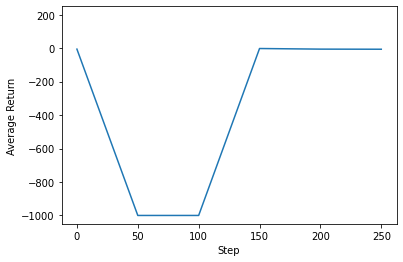

In [ ]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=250)